# Approach: item-based collaborative filtering

- Item based collaborative filtering uses the patterns of users who browsed the same item as me to recommend me a product (users who looked at my item also looked at these other items).

# Project Content

- Load data
- Exploratory data analysis
- KNN for item-based collaborative filtering

# 0. Libraries

In [2]:
!pip install numpy pandas matplotlib sklearn scipy nltk datetime tqdm gensim

  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached DateTime-4.4-py2.py3-none-any.whl (51 kB)
  Using cached gensim-4.1.2-cp39-cp39-macosx_10_9_x86_64.whl (24.0 MB)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize
from wordcloud import WordCloud
from datetime import datetime
import random
from tqdm import tqdm
from gensim.models import Word2Vec

# 1. Load Data

In [3]:
tlog = pd.read_csv(r"../data/sample_tlog.csv", index_col = 0)
product = pd.read_csv(r"../data/sample_product.csv", index_col = 0)
customer = pd.read_csv(r"../data/sample_customer.csv", index_col = 0)

In [14]:
product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2938 entries, 0 to 2937
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   upc_no                 2938 non-null   int64 
 1   upc_desc               2938 non-null   object
 2   category_no_level_1    2938 non-null   int64 
 3   category_desc_level_1  2938 non-null   object
 4   category_no_level_2    2938 non-null   int64 
 5   category_desc_level_2  2938 non-null   object
dtypes: int64(3), object(3)
memory usage: 160.7+ KB


In [13]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 1242
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            1243 non-null   int64  
 1   convenience_dim_seg    1243 non-null   object 
 2   quality_dim_seg        1243 non-null   object 
 3   health_dim_seg         1243 non-null   object 
 4   price_dim_seg          1243 non-null   object 
 5   convenience_dim_score  1243 non-null   float64
 6   quality_dim_score      1243 non-null   float64
 7   health_dim_score       1243 non-null   float64
 8   price_dim_score        1243 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 97.1+ KB


In [33]:
tlog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595306 entries, 0 to 595305
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   transaction_id       595306 non-null  object 
 1   customer_id          595306 non-null  int64  
 2   upc_no               595306 non-null  int64  
 3   category_no_level_1  595306 non-null  int64  
 4   trans_dt             595306 non-null  int64  
 5   week_no              595306 non-null  int64  
 6   store_id             595306 non-null  int64  
 7   region_cd            595306 non-null  int64  
 8   purchase_unit        595306 non-null  int64  
 9   sales_amt            595306 non-null  float64
 10  disc_amt             595306 non-null  float64
 11  purchase_price       595283 non-null  float64
dtypes: float64(3), int64(8), object(1)
memory usage: 59.0+ MB


In [68]:
sales = tlog[["customer_id", "upc_no", "purchase_unit"]].groupby(["customer_id", "upc_no"])\
.agg({"purchase_unit": "sum"}).reset_index()
sales.head()

,customer_id,upc_no,purchase_unit
0,2715888,1111018189,1
1,2715888,1657194034,1
2,2715888,1657195084,2
3,2715888,1657195210,1
4,7420205,3082,18


In [36]:
print("There are {:.0f} products, {:.0f} customers in the dataset".format(
    len(tlog.upc_no.unique()),
    len(tlog.customer_id.unique())))

There are 2938 products, 1243 customers in the dataset


# Explore Data

/var/folders/rk/t0mlngrx5mv3vz6ft_zvhhbr0000gn/T/ipykernel_74476/994306698.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_sales["log_purchase_unit"] = np.log(main_sales.purchase_unit)


<AxesSubplot:>

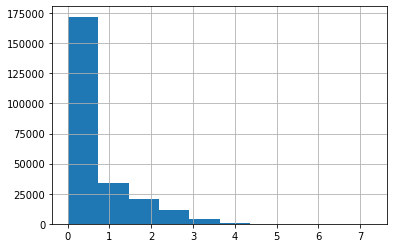

In [70]:
# only include positive quantities for now
main_sales = sales.query("purchase_unit > 0")
main_sales["log_purchase_unit"] = np.log(main_sales.purchase_unit)
main_sales.log_purchase_unit.hist()

<AxesSubplot:>

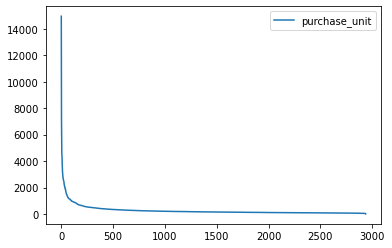

In [78]:
# purchase distribution for each product
main_sales.groupby("upc_no").agg({"purchase_unit": "sum"})\
.sort_values("purchase_unit", ascending = False).reset_index(drop = True)\
.plot()

<AxesSubplot:>

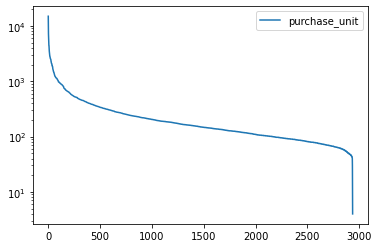

In [86]:
# purchase distribution for each product
main_sales.groupby("upc_no").agg({"purchase_unit": "sum"})\
.sort_values("purchase_unit", ascending = False).reset_index(drop = True)\
.plot(logy = True)

# KNN

In [102]:
from scipy.sparse import csr_matrix

# pivot to each row is a product, each column is a customer
prod_buyer_mat = main_sales.pivot(index = "upc_no", columns = "customer_id", values = "purchase_unit").fillna(0)

prod_to_idx = {
    prod: i for i, prod in
    enumerate(list(product.set_index("upc_no").loc[prod_buyer_mat.index].upc_desc))
}

prod_buyer_mat_sparse = csr_matrix(prod_buyer_mat.values)

In [96]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = "cosine", 
                             algorithm = "brute", 
                             n_neighbors = 20, 
                             n_jobs = -1)
model_knn.fit(prod_buyer_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

# Make product recommendation

In [111]:
!pip install fuzzywuzzy

In [112]:
from fuzzywuzzy import fuzz
def fuzzy_matching(mapper, fav_prod, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map product title name to index of the product in data

    fav_prod: str, name of user input product
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_prod.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

/Users/yuelong/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [113]:
def make_recommendation(model_knn, data, mapper, fav_prod, n_recommendations):
    """
    return top n similar product recommendations based on user's input product


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: product-user matrix

    mapper: dict, map product title name to index of the product in data

    fav_prod: str, name of user input product

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar product recommendations
    """
    # fit
    model_knn.fit(data)
    # get input product index
    print('You have input product:', fav_prod)
    idx = fuzzy_matching(mapper, fav_prod, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_prod))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [114]:
my_favorite = 'GRAPES MOON DROP'

make_recommendation(
    model_knn=model_knn,
    data=prod_buyer_mat_sparse,
    fav_prod=my_favorite,
    mapper=prod_to_idx,
    n_recommendations=10
)

You have input product: GRAPES MOON DROP
Found possible matches in our database: ['GRAPES MOON DROP', 'GRAPES COTTON CANDY']

Recommendation system start to make inference
......

Recommendations for GRAPES MOON DROP:
1: CHBN RASPBERRY GREEK YGRT, with distance of 0.5948538915704271
2: BELG FRSH MOZARELLA BALLS, with distance of 0.5504767921792009
3: CARROTS BUNCH ORGNC RPC, with distance of 0.5444328673179748
4: GRDH WATERMELON CHUNKS, with distance of 0.44588460032211086
5: LAYS LIGHTLY SALTED CHIPS, with distance of 0.44582957896886266
6: BKRY SS DONUTS, with distance of 0.3757515928326228
7: CHBN NF PLAIN YOGURT, with distance of 0.2711775334524543
8: CHERRIES BING CHILEAN BAG, with distance of 0.20205014209235872
9: WTRMLN SEED PREM CUT IS, with distance of 0.174136715728185
10: GRDH WATERMELON SPEARS, with distance of 0.1536902178890882
